# GD12.CV. 프로젝트: End-to-End OCR
##### !. Aiffel cloud 플랫폼을 사용하여 Python 3.9.7버전에서 작성되었습니다.

In [22]:
!python --version

Python 3.9.7


---

### 목차

- STEP 0. 주요 라이브러리 import 및 데이터셋 불러오고 모델 구현.
- STEP 1. keras-ocr의 Detector 사용
- STEP 2. Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보기
- 회고록   
- Reference

---

### (서론)

이미지에서 단어를 추출하는 것은 복합적인 단계가 들어간다.  
이번 프로젝트에서는 이러한 구조를 이해하고 OCR을 만들기 위해 keras-ocr을 활용하여, Text Recognition을 직접 만들어보고자 한다.

---

### (본문)

### STEP 0. 주요 라이브러리 import 및 데이터셋 불러오고 모델 구현


- `Keras-ocr`
  - OCR은 이미지 속에서 영문을  Bounding box로 찾아내고 그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템.
  - 이미지 속에서 문자영역을 찾아내는 것인 Text Detection은 Segmentation 기반의 CRAFT를 활용한 `Keras-ocr`을 활용할 예정

In [3]:
%%capture
!pip install keras_ocr

In [37]:
import re
import six
import math
import lmdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import keras_ocr
print("library import success")

library import success


#### 데이터셋

- OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야하는 번거로움이 있음.
- OCR데이터를 대량으로 만들기 위해 큰 비용이 소모.
- 데이터 문제를 해결하기 위한 방법 중 하나로 컴퓨터로 대량 문자 이미지 데이터를 만들어냄.
- [논문](https://arxiv.org/pdf/1904.01906.pdf)에서 Recognition의 정량적인 평가를 위해서 [MJSynth](http://www.robots.ox.ac.uk/~vgg/data/text/)와 [SynthText](http://www.robots.ox.ac.uk/~vgg/data/scenetext/)라는 데이터셋을 활용했기에 여기서도 활용

In [38]:
BATCH_SIZE = 128
DATA_DIR = '/aiffel/aiffel/GD_12_OCR/ocr/data'

# MJ 데이터셋 위치
TRAIN_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_train')
VALID_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_valid')
TEST_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_test')

- LMDB: Symas에서 만든 Lightning Memory-Mapped Database 의 약자
- 이번프로젝트에서 다루게 될 `데이터셋`이 lmdb 포햄(mdb)의 파일로 이루어져 있음.
- lmdb를 통해 훈련데이터셋 이미지를 4개만 열어서 확인(shape, 이미지, 라벨)
    - 이미지의 대부분은 height 31, 최대 32되어 있음.
    - width 는 문자열 길이에 따라 다양함.

━━━━━━━━ 1 ━━━━━━━━
original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


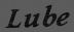

━━━━━━━━ 2 ━━━━━━━━
original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


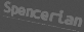

━━━━━━━━ 3 ━━━━━━━━
original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


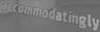

━━━━━━━━ 4 ━━━━━━━━
original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


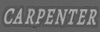

In [39]:
# env에 데이터를 불러옴.
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적.
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 오픈
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있음.
with env.begin(write=False) as txn:
    for index in range(1, 5):
        print(f"━━━━━━━━ {index} ━━━━━━━━")
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있음.
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요.
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력.
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀예정.
        # 하지만 너비를 100보다는 작게함.
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있음.       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- lmdb를 활용한 케라스 모델 학습용 `MJSynth` 데이터셋 클래스 구현
- `dataset_path`는 읽어들일 데이터셋의 경로. 
- `label_converter`는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 함.
- `batch_size`와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있음.
- 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 `_get_img_label()` 메소드에 반영됨.
- `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴하게 됨.
- `_get_img_label()` 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있음.

In [40]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둠.
    # 또, lmdb에 있는 데이터 수를 미리 파악.
    def __init__(self, 
                dataset_path,
                label_converter,
                batch_size=1,
                img_size=(100,32),
                max_text_len=22,
                is_train=False,
                character='') :
        
        self.label_converter = label_converter  # 문자를 미리 정의된 index로 변환해주는 converter
        self.batch_size = batch_size  # 배치 사이즈
        self.img_size = img_size  # 입력 이미지 크기
        self.max_text_len = max_text_len  # 최대 글자 수
        self.character = character  # 학습 대상으로 한정하기 위한 character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옴.
    # 위에서 사용한 코드와 매우 유사.
    # label을 조금 더 다듬는 것이 약간 다름

    # - 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
    # => 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬음
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드.
    # 이 부분을 작성하면 slice할 수 있음.
    # 자세한 내용은 아래 문서를 참고.
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__

    # - model.fit() 에서 호출되는 메서드: 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
    def __getitem__(self, idx):
        # 1. idx에 해당하는 index_list만큼 데이터를 불러
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2. image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있음.
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 사용하기 좋은 inputs과 outputs형태로 반환함.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("Class")

Class


- Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있으나, 이것은 모델을 학습하기 위해서는 적절한 형태가 아님
- 따라서 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 함.
- 이를 가능하게 하는 `LabelConverter`클래스를 작성.
  - `__init__()`에서는 입력으로 받은 text를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어짐. 만약 `character='ABCD'`라면 `'A'`의 label은 1, `'B'`의 label은 2가 됨.
  - 공백(blank) 문자를 지정. 여기서는 공백 문자를 뜻하기 위해 `'-'`를 활용하며, label은 0으로 지정.
  - `decode()`는 각 index를 다시 character로 변환한 후 이어주어 사용자가 읽을 수 있는 text로 바꾸어줌.

  

In [41]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    
            encoded_label.append(self.label_map[char])

        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

- 영문 대문자와 숫자를 인식하기 위해서 필요한 Class 개수: 36
    - 문자가 없는 경우 공백 추가해야 하므로 37개

In [42]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")  # 36

The total number of characters is 36


- 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인
    - 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자('-')가 포함됨

In [43]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)  # [ 8  5 12  0 12 15]
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)  # HEL-LO

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


- MJDatasetSequence 로 데이터셋 분리

In [44]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

print(f'Train DataSet 개수: {len(train_set)}')  # 565
print(f'Valid DataSet 개수: {len(val_set)}')  # 63
print(f'Test DataSet 개수: {len(test_set)}')  # 70

Train DataSet 개수: 565
Valid DataSet 개수: 63
Test DataSet 개수: 70


#### Text Recognition Model: CTC 학습 CRNN Model

- CTC Loss 함수를 구현하기 위해 이 함수에 인자로 어떤 값을 넘겨야 하는지 명확하게 파악할 필요가 있음.
- 텐서플로우 듀토리얼에 따르면 4가지 인자가 존재
  - `y_true`: tensor (samples, max_string_length) containing the truth labels.
  - `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
  - `input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.
  - `label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.
  
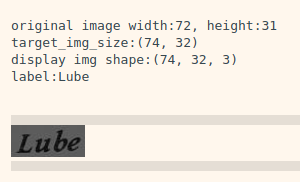  
- 케이스를 예로 들었을 때 인자 해석
  - `y_true`: 실제 라벨 `LUBE`. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
  - `y_pred`: 우리가 만들 RCNN `모델의 출력 결과`. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
  - `input_length tensor`: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 `74`
  - `label_length tensor`: 라벨의 실제 정답 길이 U로서, 이 경우에는 `4`

- 앞선 단계에서 입력과 출력을 준비. 
- 이제는 모델을 만들어볼 차례.
- Keras에서 제공하는 `K.ctc_batch_cost()`를 활용해서 loss를 계산하도록 `ctc_lambda_func`를 아래와 같이 만듬.

In [45]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("CTC los 함수 구현")

CTC los 함수 구현


- Recognition Model
    - CRNN 구조<br>![](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-3.crnn_structure.png)
    - CTC Loss
    - 이미지 입력 레이어: input_image
    - 라벨 출력 레이어: output

- `K.ctc_batch_cost()`를 활용하여, `image_input`을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 `build_crnn_model()`을 구현.

In [46]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # Conv Layers
    # Feature 추출
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)

    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # Recurrent Layers
    # 추출된 Feature 의 전체적인 Context 파악
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)

    # Transcription Layer(=Fully Connected Layer)
    # Step 마다 어떤 Character 의 확률이 높은지 예측
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # CRNN 모델 생성
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model

- 모델 생성

In [47]:
model = build_crnn_model()

- 모델 구조

In [48]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 50, 16, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 50, 16, 128)  73856       max_pooling2d_8[0][0]            
___________________________________________________________________________________________

- 모델 구조 시각화

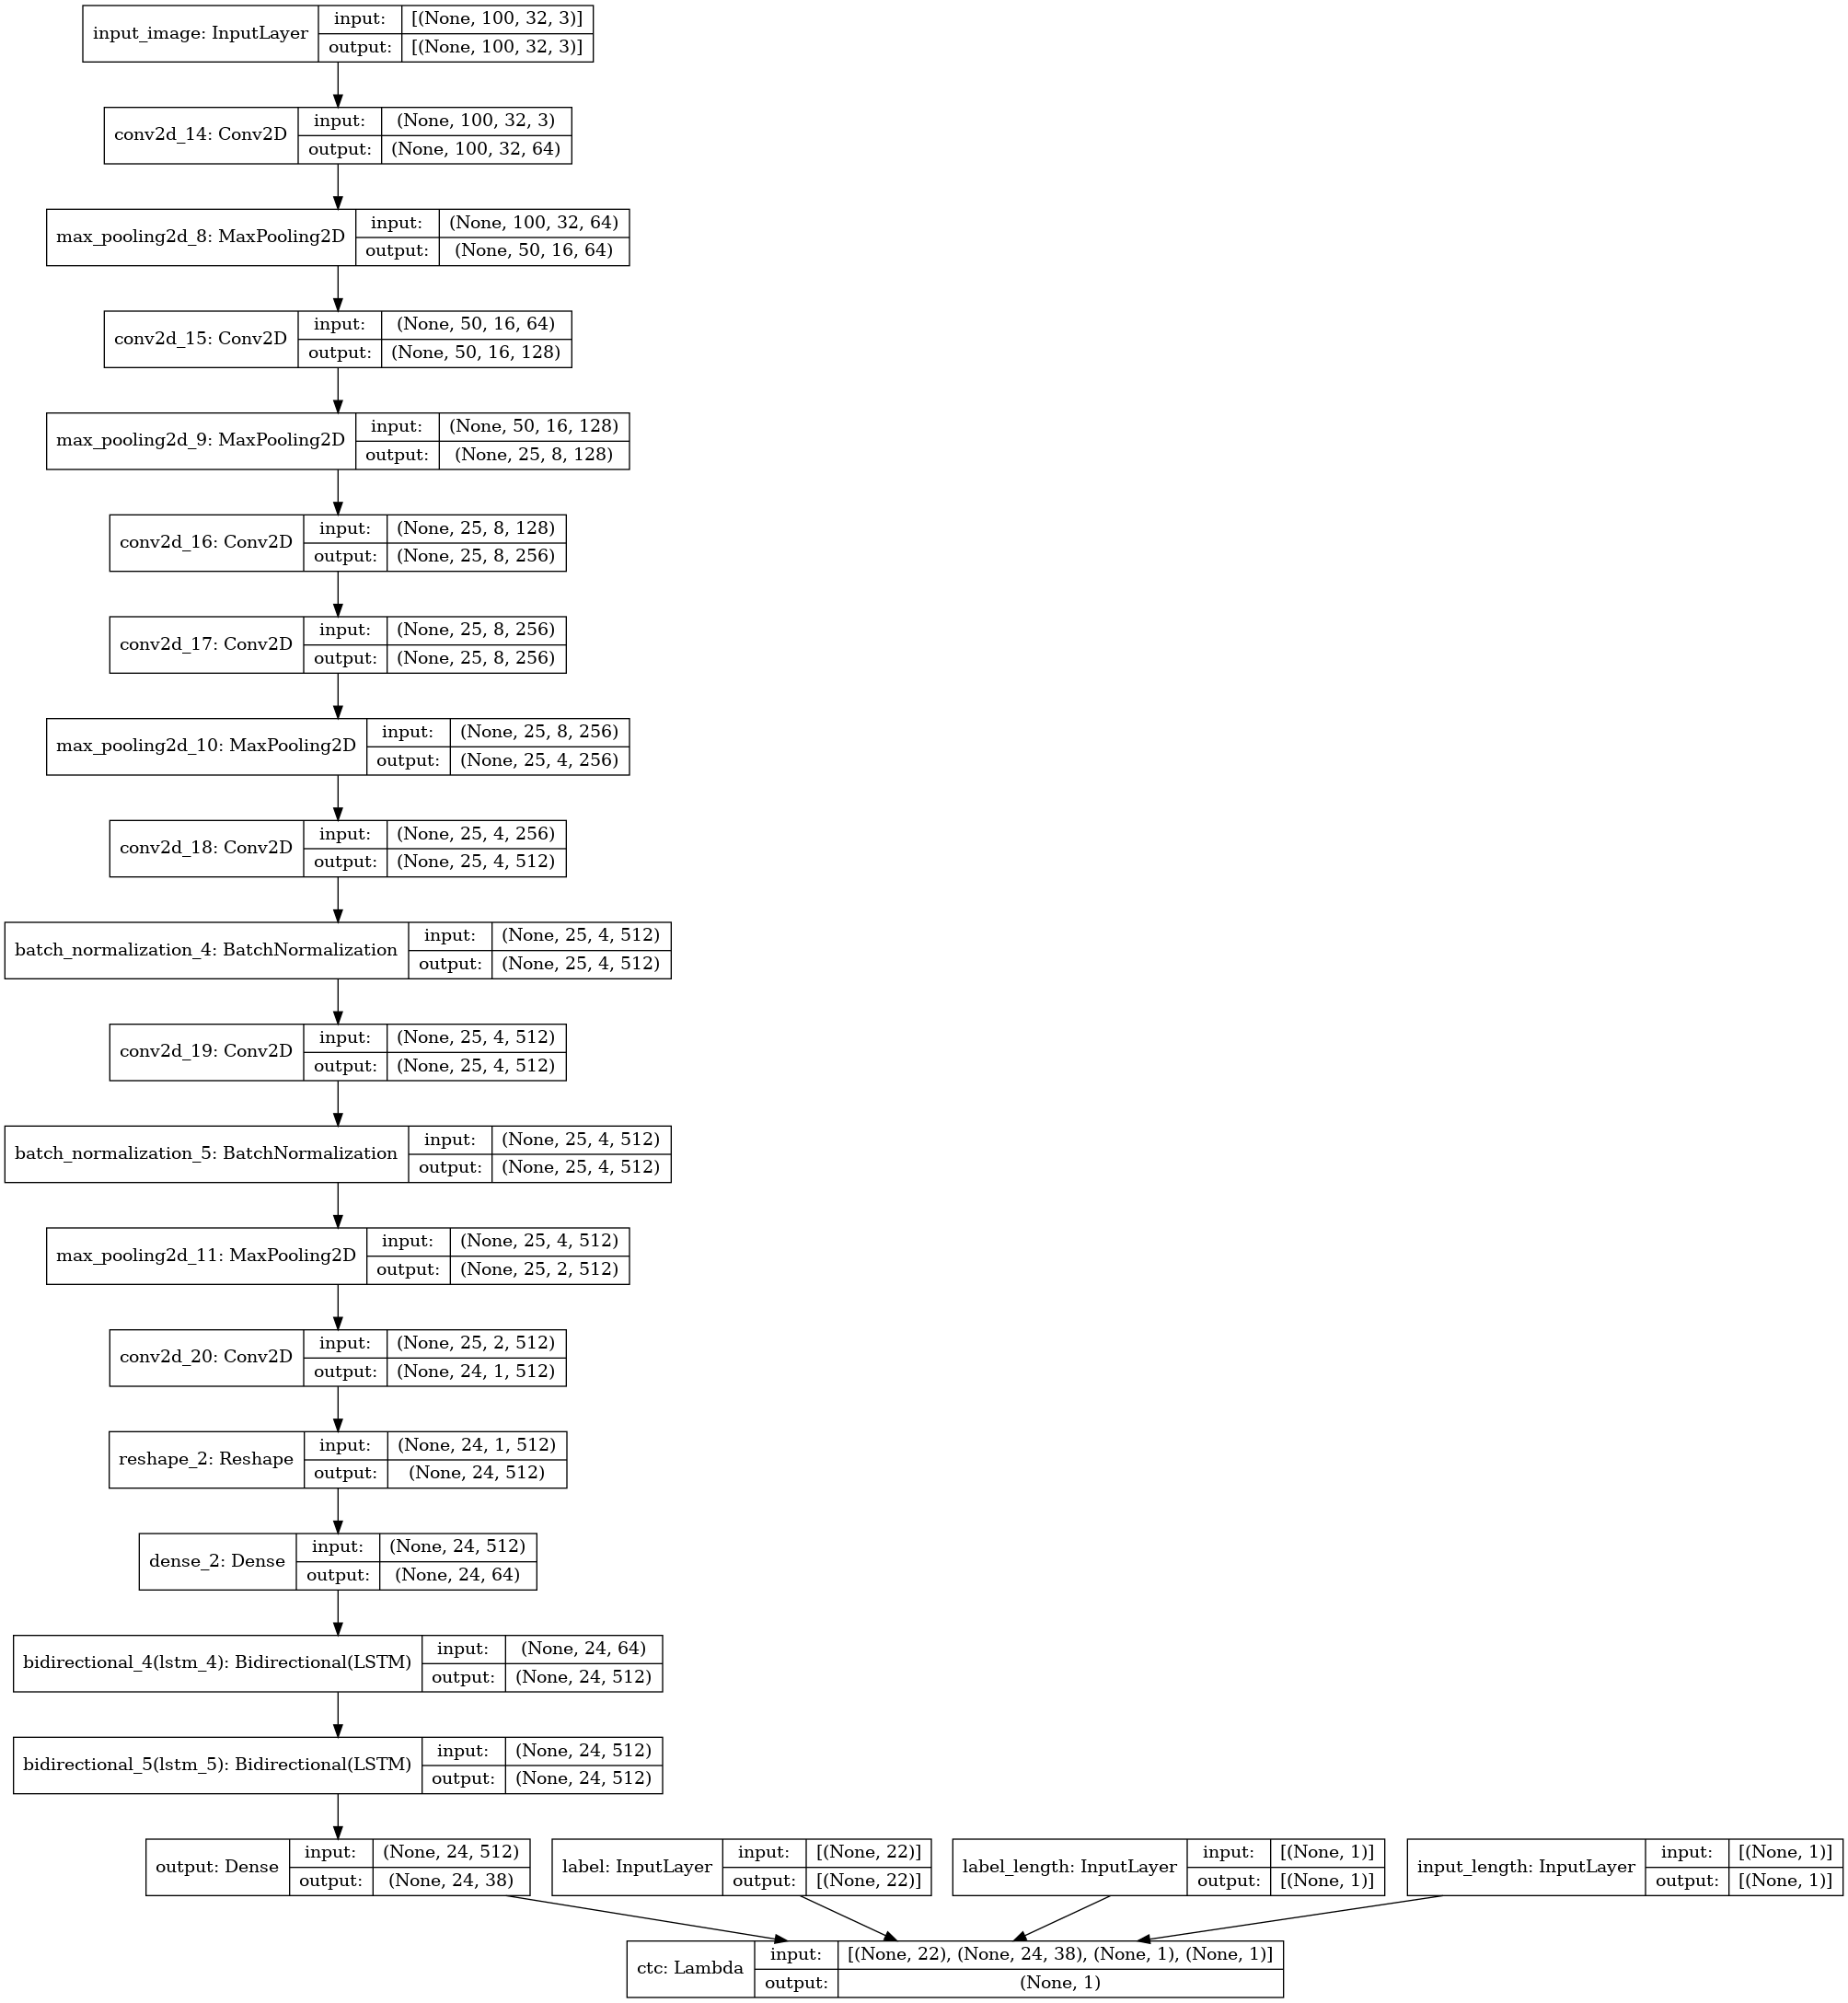

In [49]:
plot_model(model, to_file=f'result/Recognition_CRNN_shapes.png', show_shapes=True)

- 모델 훈련 및 저장

In [50]:
# 모델을 컴파일.
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(
    optimizer=optimizer,
    loss={'ctc': lambda y_true, y_pred: y_pred},
    metrics=['accuracy'],
)

In [51]:
EPOCHS=50

In [52]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용하는 것이 좋으나 여기서는 끝까지 학습을 돌림
checkpoint_path = os.path.join(DATA_DIR, f'model_checkpoint_{EPOCHS}.hdf5')
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
crnn_history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set),
    #callbacks=[ckp]
    #callbacks=[ckp, earlystop]
)

Epoch 1/50
565/565 [==============================] - 89s 148ms/step - loss: 25.6166 - accuracy: 0.0000e+00 - val_loss: 22.9735 - val_accuracy: 0.0000e+00
Epoch 2/50
565/565 [==============================] - 82s 145ms/step - loss: 15.1096 - accuracy: 8.9878e-04 - val_loss: 10.6692 - val_accuracy: 0.0118
Epoch 3/50
565/565 [==============================] - 82s 146ms/step - loss: 7.0537 - accuracy: 0.0855 - val_loss: 6.4605 - val_accuracy: 0.1448
Epoch 4/50
565/565 [==============================] - 82s 146ms/step - loss: 5.0034 - accuracy: 0.2561 - val_loss: 5.1750 - val_accuracy: 0.2671
Epoch 5/50
565/565 [==============================] - 82s 146ms/step - loss: 3.9495 - accuracy: 0.3811 - val_loss: 4.4463 - val_accuracy: 0.3707
Epoch 6/50
565/565 [==============================] - 82s 145ms/step - loss: 3.2045 - accuracy: 0.4708 - val_loss: 4.3028 - val_accuracy: 0.4195
Epoch 7/50
565/565 [==============================] - 82s 146ms/step - loss: 2.6208 - accuracy: 0.5411 - val_loss:

- 학습 결과 시각화

In [53]:
def draw_unet_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f'result/{model_name}_Result.png')  # 저장
    plt.show()

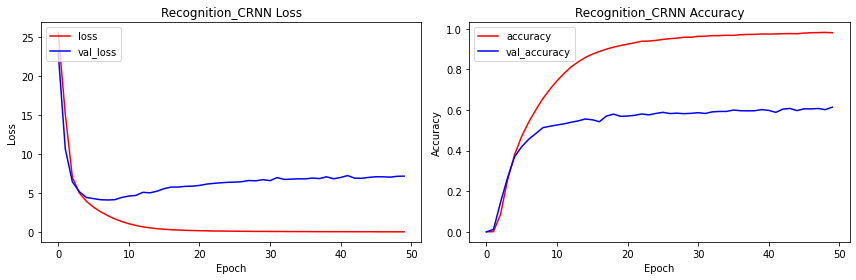

In [54]:
draw_unet_history(crnn_history, 'Recognition_CRNN')

- 저장한 모델 불러오기

In [55]:
# 다음은 20 Epochs 이상 학습된 모델의 가중치가 저장된 경로.
checkpoint_path = os.path.join(DATA_DIR, f'model_checkpoint_{EPOCHS}.hdf5')

In [56]:
model = build_crnn_model()
model.load_weights(checkpoint_path)

- Inference 모델 생성
    - CRNN 모델 입력 중 input_image 만 사용

In [57]:
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없음.
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만듬.
# inference 전용 모델.
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

- Inference 결과 확인
    - 학습된 모델의 성능을 테스트셋을 통해 확인

In [58]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 함.
# 코드 하나하나를 이해하기는 조금 어려울 수 있음.
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        # 의미없는 인덱스 -1 위치 숫자 9 출력 방지
        if index == -1:
            continue
        # 예측한 문자 저장
        text += chars[index]
    return text

# 모델과 데이터셋이 주어지면 inference를 수 있음.
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력.
def check_inference(model, dataset, index = 5):
    for i in range(index):
        print(f"━━━━━━━━ {i} ━━━━━━━━")
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1,:,:,:]
        output = model.predict(img)  # 모델 예측

        # 예측
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
        print(f"Result: \t{result}")
        
        # 라벨
        label = ''.join(map(lambda x: label_converter.decode(x), inputs['label'][0:1,])).replace('-','')
        print(f"Label:  \t{label}")

        # 예측, 라벨 인덱스별로 비교해서 같으면 1, 다르면 0 표시
        is_right = ''.join(map(lambda x: '1' if x[0] == x[1] else '0', zip(result, label)))
        print(f"Is_Right:\t{is_right}")

        # 맞춘 문자 개수, 점수 계산
        is_right_count = is_right.count('1')
        print(f"Is_Right_Count:\t{is_right_count}/{len(label)}")
        print(f"Score: {is_right_count/len(label):.2f}")

        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

━━━━━━━━ 0 ━━━━━━━━
Result: 	SLINKING
Label:  	SLINKING
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


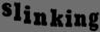

━━━━━━━━ 1 ━━━━━━━━
Result: 	ALEPPO
Label:  	ALEPPO
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


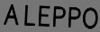

━━━━━━━━ 2 ━━━━━━━━
Result: 	RWANDA
Label:  	RWANDA
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


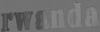

━━━━━━━━ 3 ━━━━━━━━
Result: 	NATHANS
Label:  	NATHANS
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


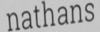

━━━━━━━━ 4 ━━━━━━━━
Result: 	HAL
Label:  	HALLOO
Is_Right:	111
Is_Right_Count:	3/6
Score: 0.50


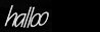

━━━━━━━━ 5 ━━━━━━━━
Result: 	HURLS
Label:  	HURLS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


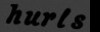

━━━━━━━━ 6 ━━━━━━━━
Result: 	DOWNSIZE
Label:  	DOWNSIZE
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


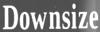

━━━━━━━━ 7 ━━━━━━━━
Result: 	ROBOTIC
Label:  	ROBOTIC
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


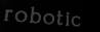

━━━━━━━━ 8 ━━━━━━━━
Result: 	SLOPPY
Label:  	SLOPPY
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


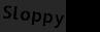

━━━━━━━━ 9 ━━━━━━━━
Result: 	HERMITE
Label:  	HERMITE
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


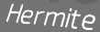

━━━━━━━━ 10 ━━━━━━━━
Result: 	DEARS
Label:  	DEARS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


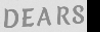

━━━━━━━━ 11 ━━━━━━━━
Result: 	POLYSYLABIC
Label:  	POLYSYLLABIC
Is_Right:	11111110000
Is_Right_Count:	7/12
Score: 0.58


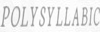

━━━━━━━━ 12 ━━━━━━━━
Result: 	DER
Label:  	DENSE
Is_Right:	110
Is_Right_Count:	2/5
Score: 0.40


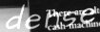

━━━━━━━━ 13 ━━━━━━━━
Result: 	DIAERESES
Label:  	DIAERESES
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


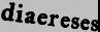

━━━━━━━━ 14 ━━━━━━━━
Result: 	HUMAPBACKS
Label:  	HUMPBACKS
Is_Right:	111000000
Is_Right_Count:	3/9
Score: 0.33


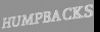

━━━━━━━━ 15 ━━━━━━━━
Result: 	NDOPTEDL
Label:  	ADOPTED
Is_Right:	0111111
Is_Right_Count:	6/7
Score: 0.86


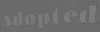

━━━━━━━━ 16 ━━━━━━━━
Result: 	MILWAUKEE
Label:  	MILWAUKEE
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


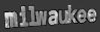

━━━━━━━━ 17 ━━━━━━━━
Result: 	SPECIFICATION
Label:  	SPECIFICATION
Is_Right:	1111111111111
Is_Right_Count:	13/13
Score: 1.00


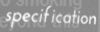

━━━━━━━━ 18 ━━━━━━━━
Result: 	REACTIONARY
Label:  	REACTIONARY
Is_Right:	11111111111
Is_Right_Count:	11/11
Score: 1.00


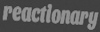

━━━━━━━━ 19 ━━━━━━━━
Result: 	OSCEOLA
Label:  	OSCEOLA
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


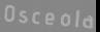

In [59]:
check_inference(model_pred, test_set, index=20)

---

### STEP 1. keras-ocr의 Detector 사용

#### End-to-End OCR

- Text Detection 수행 함수
    - 이미지 경로를 받아 해당 이미지 내의 문자 찾아내기
        - **Keras-OCR 의 Detector 사용**
        - inference 후 시각화
        - 단어 영역 잘라내기

In [60]:
def detect_text(img_path, detector):
    
    # 이미지 불러오기
    img_pil = Image.open(img_path).convert('RGB')  # (1200, 900, 3)

    # 1. Keras-OCR 의 Detection 모델에 입력하기 위한 이미지 전처리
    # - 이미지 비율 유지해서 resize() 적용
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(H,W,C) 여야 모델 입력시 제대로 동작함
    width, height = img_pil.size  # 원본 이미지 크기
    target_width = min(int(width*300/height), 400)  # 이미지 비율 유지, 높이 300, 너비는 400 보다 작게 설정
    target_img_size = (target_width,300)

    img_pil = img_pil.resize(target_img_size)  # (400, 300, 3)
    img_pil_copy = img_pil.copy()

    img_pil = np.array(img_pil)  # (300, 400, 3)
    img_pil = np.expand_dims(img_pil, axis=0)  # (1, 300, 400, 3)
    
    # 2. 모델 예측
    # - OCR 텍스트 검출 결과
    # - 배치 첫 번째 결과 가져오기
    detect_result = detector.detect(img_pil)  # 타입: list
    ocr_result = detect_result[0]  # 타입: np.array
	
    # 3. display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    img_pil = np.squeeze(img_pil, axis=0).astype(np.uint8)  # (300, 400, 3)
    img_pil = Image.fromarray(img_pil)
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []  # 단어 영역
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil_copy.crop(word_box))
    
    return img_pil, cropped_imgs

### STEP 2. Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보기

- Text Recognition 수행 함수
    - 잘려진 단어 이미지 인식
        - 단어 영역 시각화
        - **앞서 구현한 CTC 학습 CRNN Model 사용**
        - 인식한 문자 출력

In [61]:
def recognize_img(idx, pil_img, model_pred, input_img_size=(100,32)):
    # CRNN 기반의 Recognition 모델에 입력하기 위한 이미지 전처리
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(W,H,C) 여야 모델 입력시 제대로 동작함
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.array(pil_img)  # (32, 100, 3)
    pil_img = pil_img.transpose(1,0,2)  # (100, 32, 3)
    pil_img = np.expand_dims(pil_img, axis=0)  # (1, 100, 32, 3)
    
    # 모델 예측
    # - OCR 텍스트 인식 결과 출력
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
    print("Result: \t", result)
    
    # display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    pil_img = np.squeeze(pil_img, axis=0).transpose(1,0,2).astype(np.uint8)  # (32, 100, 3)
    pil_img = Image.fromarray(pil_img)
    pil_img.save(f'result/Text_Recognition_{idx}.png')  # 저장
    display(pil_img)

- End-to-End OCR 수행 함수
    - keras-ocr detector
    - CRNN recognizer

In [62]:
def end_to_end_ocr(img_path, detector, model_pred):
    # Text Detection
    print('━━━━━━━━ Text Detection ━━━━━━━━')
    img_pil, cropped_img = detect_text(img_path, detector)
    img_pil.save(f'result/sample.png')  # 저장
    display(img_pil)

    # Text Recognition
    print('━━━━━━━━ Text Recognition ━━━━━━━━')
    for idx, _img in enumerate(cropped_img):
        recognize_img(idx, _img, model_pred)

- End-to-End OCR 결과 확인

In [63]:
SAMPLE_IMG_PATH = os.path.join(DATA_DIR, 'sample.jpg')

In [64]:
detector = keras_ocr.detection.Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


━━━━━━━━ Text Detection ━━━━━━━━


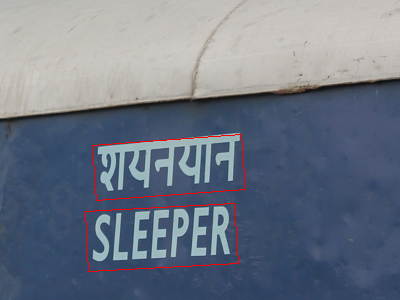

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 TFUIFT


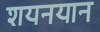

Result: 	 SLEEPER


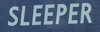

In [65]:
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
━━━━━━━━ Text Detection ━━━━━━━━


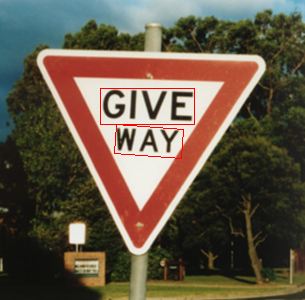

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 GIVE


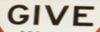

Result: 	 WAVA


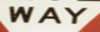

In [71]:
SAMPLE_IMG_PATH = os.path.join(DATA_DIR, 'sample2.png')
detector = keras_ocr.detection.Detector()
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
━━━━━━━━ Text Detection ━━━━━━━━


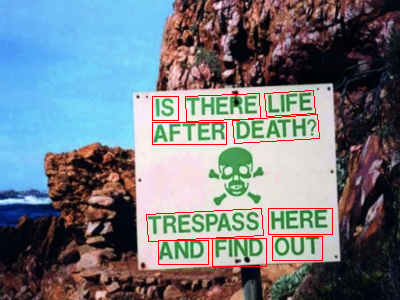

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 LIGE


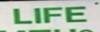

Result: 	 THE


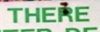

Result: 	 UNGSN


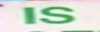

Result: 	 DEATHIR


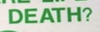

Result: 	 AFTER


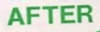

Result: 	 HERE


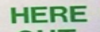

Result: 	 TRESPASS


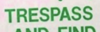

Result: 	 OI


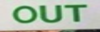

Result: 	 FLNPS


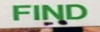

Result: 	 ARIDR


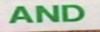

In [69]:
SAMPLE_IMG_PATH = os.path.join(DATA_DIR, 'sample3.png')
detector = keras_ocr.detection.Detector()
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
━━━━━━━━ Text Detection ━━━━━━━━


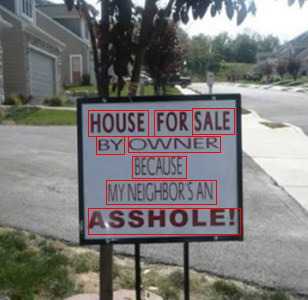

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 SALE


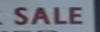

Result: 	 HOUSE


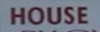

Result: 	 SFORS


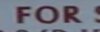

Result: 	 JIEATVL


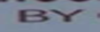

Result: 	 OWINER


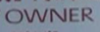

Result: 	 BECAUSES


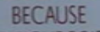

Result: 	 MINEGHBORSAL


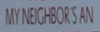

Result: 	 ASSHOLEL


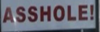

In [70]:
SAMPLE_IMG_PATH = os.path.join(DATA_DIR, 'sample4.png')
detector = keras_ocr.detection.Detector()
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

---

### (결론)

- 모델의 정확성 해석
  - 각 단어의 크기가 균일하고, 짧은 경우 단어를 잘 인식함.
  - 글자의 크기가 다르고, 길어질 경우 단어를 잘 인식하지 못함.

---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다. | |텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다. | |
|RNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다. | |학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다. | |
|keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다. | |샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다. | |

---

### 회고록.

OCR모델을 직접 구현하기 위해 Text Recognition 모델을 직접 구현해보는 여섯번째 고잉디터 exp 프로젝트였다.  
여러 모델들과 RNN, CNN을 같이 사용하여 OCR기능을 구현한다는 점이 이미지에서 글자를 출력하기 위해서는 어찌보면 당연한 생각임에도 구현하는 것은 쉽지 않다는 생각이 들었다.  
사용자 맞춤 OCR을 만들고 싶은데 모델의 정확도와 각상황에 맞는 학습을 시키기 위해 대부분의 글자 데이터를 직접 만드는 것이 개인이용자에게는 너무 어려운 일이라 결국 외부 API를 사용해야 하는 상황이 너무 아쉽게만 느껴진다.  
개인이 모델의 정확도를 높이기 위한 방법이(기반모델 변경, 폰트에 따른데이터셋 자동생성)무엇이 있을지 찾아보고 구현해볼 필요가 있음.


---

### Reference. (APA)

faustomorales.keras-ocr.github.https://github.com/faustomorales/keras-ocr

---